# What is the infrared sky background?

Here we use the data from Oliva+ (2015) to compute the inter-line sky background.


In [299]:
import numpy as np
import os
%matplotlib inline
from pylab import *

import astropy
from astropy.convolution import convolve

rcParams["font.size"]=24

Read in the night sky spectrum from Oliva 2015

In [300]:
dat = np.loadtxt("data/Oliva2015/table4.dat")
ll,ss = dat.T

mosdat = np.loadtxt("data/Mosfire-sky-background/mosfire-130429.dat")
llm, ssm = mosdat.T
llm = (llm*1.62695+14500-1.62695)


Filter curves from MOSFIRE bandpass definitions

In [301]:
Y = "Y" ; J = "J" ; H = "H" 

filters = {Y: (.972, 1.124), J: (1.153, 1.352), H: (1.466, 1.807)}

Make the luminosity specific in wavelength

## compare to paper


![alt text](fig3.png "Title")


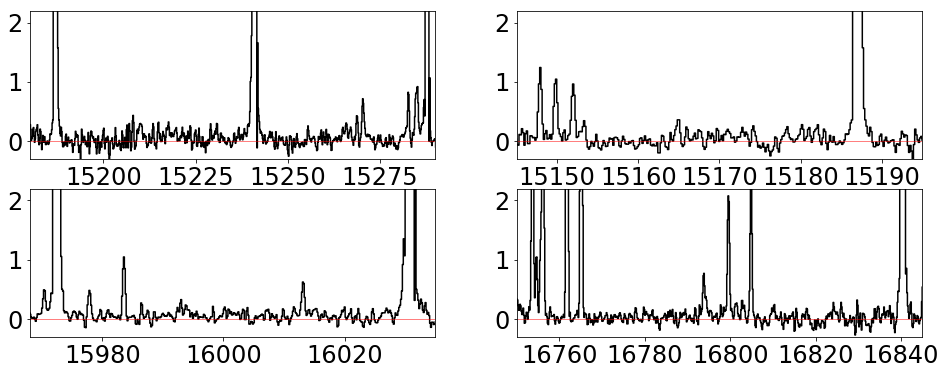

In [302]:
fig = figure(figsize=(16,6))

locs = [(15180, 15290), (15145, 15195), (15968, 16035), (16750, 16845)]

for ix, loc in enumerate(locs):
    subplot(2,2,ix+1)
    step(ll, ss, 'k')

    axhline(0, color='r', lw=.5)
    xlim(*loc)
    ylim(-.3,2.2)


# Now convolve down the spectrum - Compare MOSFIRE to GIANO

In [303]:
kernel = astropy.convolution.Box1DKernel(width=60)

In [304]:
ss_smooth = convolve(ss, kernel)

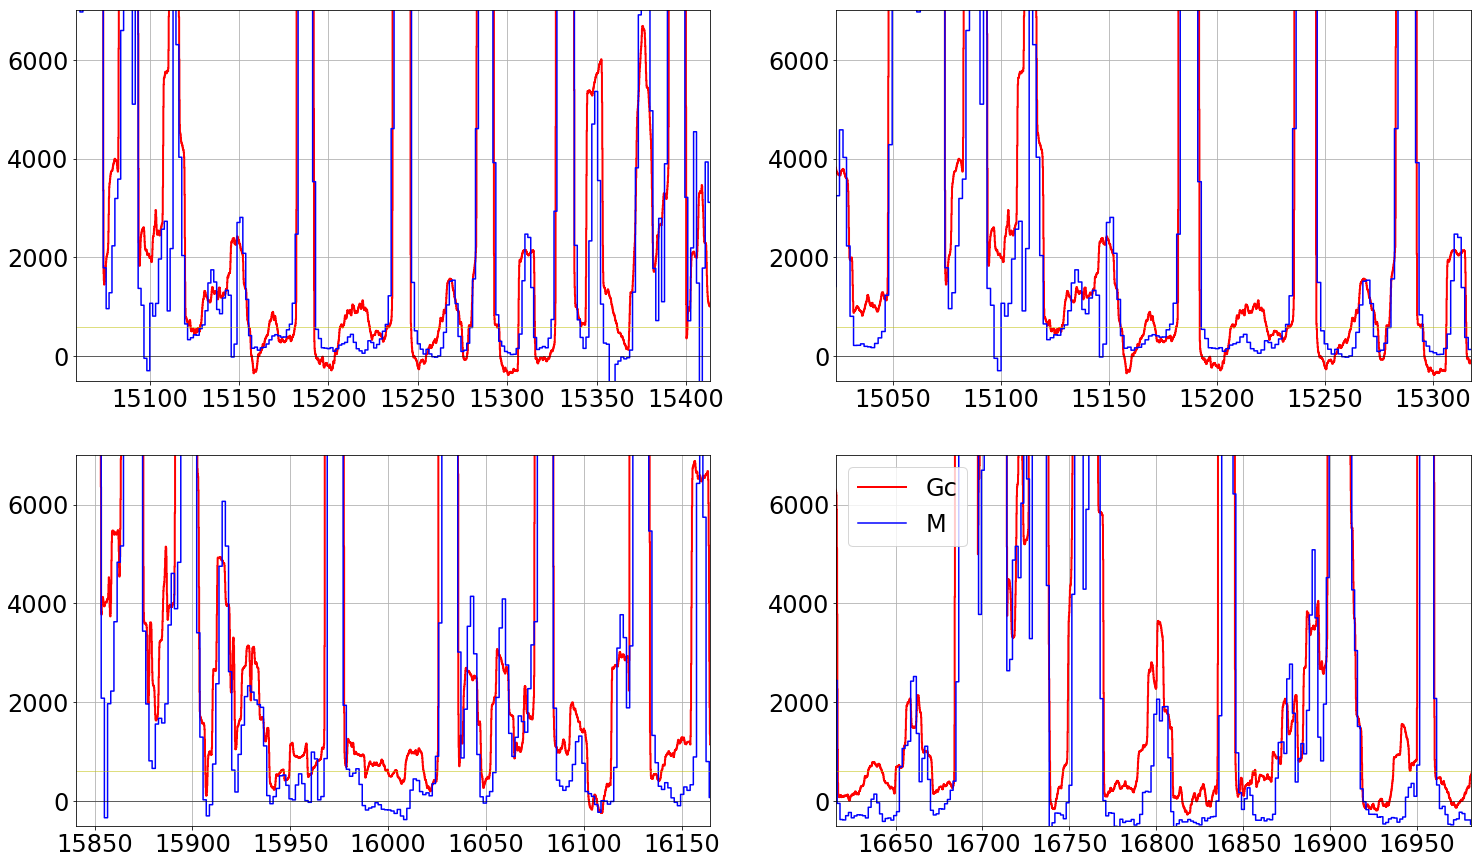

In [305]:
fig = figure(figsize=(25,15))

angs_to_mic = 1e4
locs = [(15180, 15290), (15145, 15195), (15968, 16035), (16750, 16845)]

F = .992
zpt = np.percentile(ssm,25)

for ix, loc in enumerate(locs):
    subplot(2,2,ix+1)
    #step(ll, ss*angs_to_mic/10, 'k', lw=1)
    step(ll, ss_smooth*angs_to_mic, 'r', lw=2)
    step(llm+16, (ssm-zpt)*13, 'b')

    axhline(0, color='k', lw=.5)
    axhline(600, color='y', lw=.5)
    
    xlim(loc[0]*F, loc[1]/F)
    ylim(-500,7000)
    grid(True)

legend(["Gc", "M"])



Note in the figure above the zero-point of the MOSFIRE spectra don't match the zero-point of GIANO well; however, very little care was taken to zeropoint the MOSFIRE spectra, so I tend to trust the GIANO results.

# Boost background to 300 

(-100, 800)

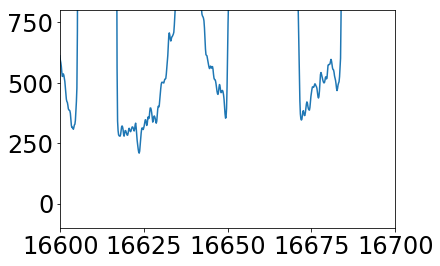

In [331]:
GIANO_spec = ss_smooth + 200/angs_to_mic

plot(ll, GIANO_spec*angs_to_mic)


xlim(16610-10, 16690+10)
ylim(-100, 800)

# Now look at background limit

I define background limit as shot noise is 2x the read noise. This way the read noise amounts to about 25% of the total noise.

In [332]:
RN = 5.8 # For MOSFIRE, seems reasonable for H2RGs with 16 Fowler samples
Goal = (2*RN)**2
print("For a read noise of %s the desired sky shot noise is %2.1f and signal of %i photon" % (RN, 2*RN, Goal))

For a read noise of 5.8 the desired sky shot noise is 11.6 and signal of 134 photon


In [362]:
# Bandwidth
sampling_pix = 2.5 # pixels per slit width
R = 3700

BW_pix = 15200/R/sampling_pix

# Magellan
Dtel = 6.5
Atel = np.pi*(Dtel/2)**2 - np.pi*(Dtel*.25/2)**2
Omega = 0.25**2
Gs = {"Magellan": Atel * Omega}

# Mosfire
Dtel = 10
Atel = np.pi*(Dtel/2)**2 - np.pi*(Dtel*.25/2)**2
Omega = 0.18**2 * 1.4
Gs["MOSFIRE"] = Atel * Omega




print("Gs")
print(" MOSFIRE: %2.1f" % Gs["MOSFIRE"])
print("Magellan: %2.1f" % Gs["Magellan"])


Gs
 MOSFIRE: 3.3
Magellan: 1.9


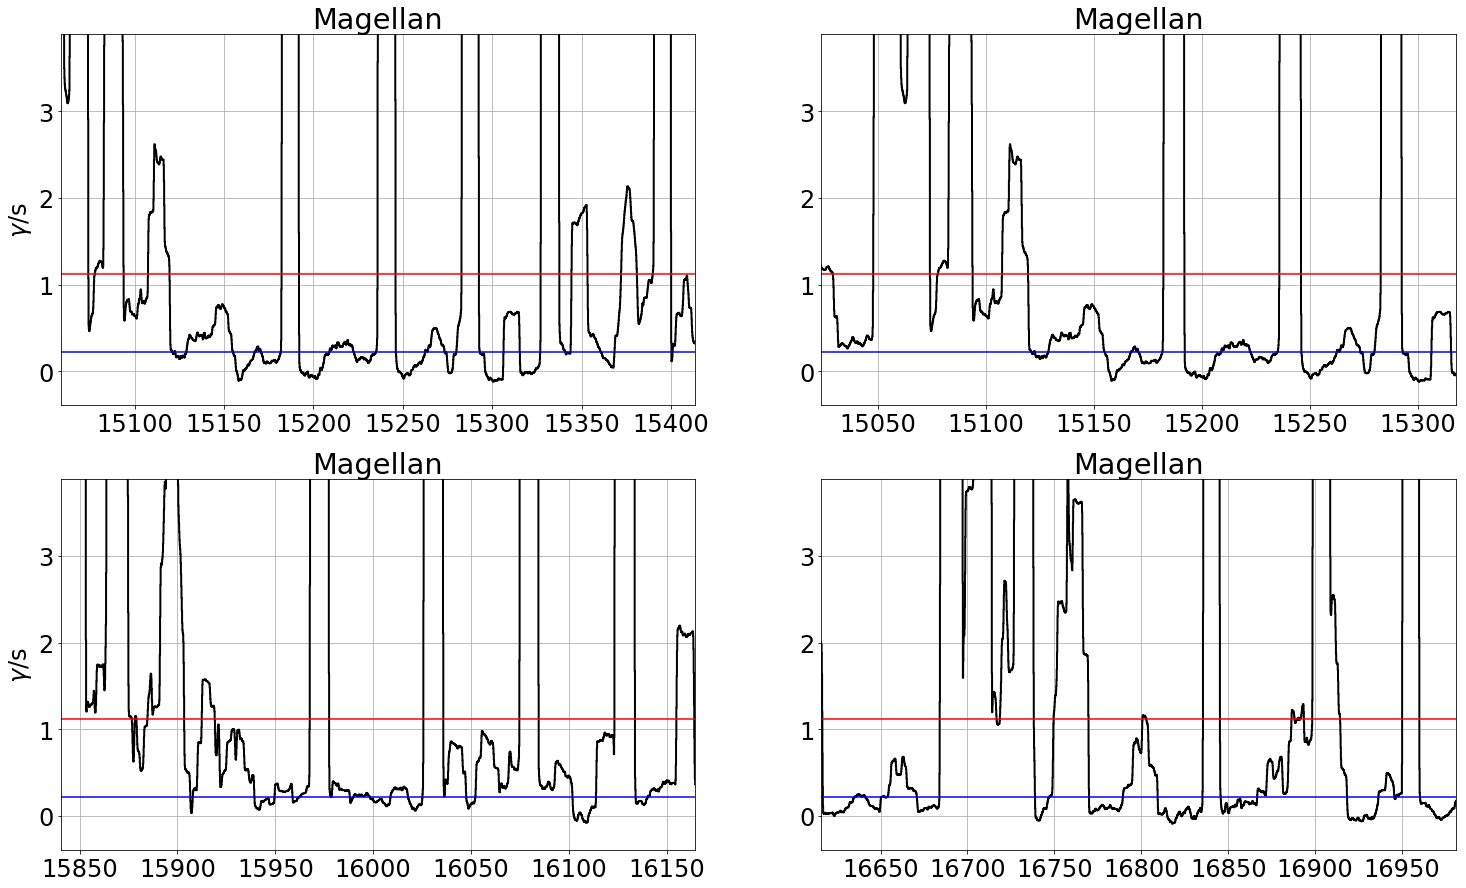

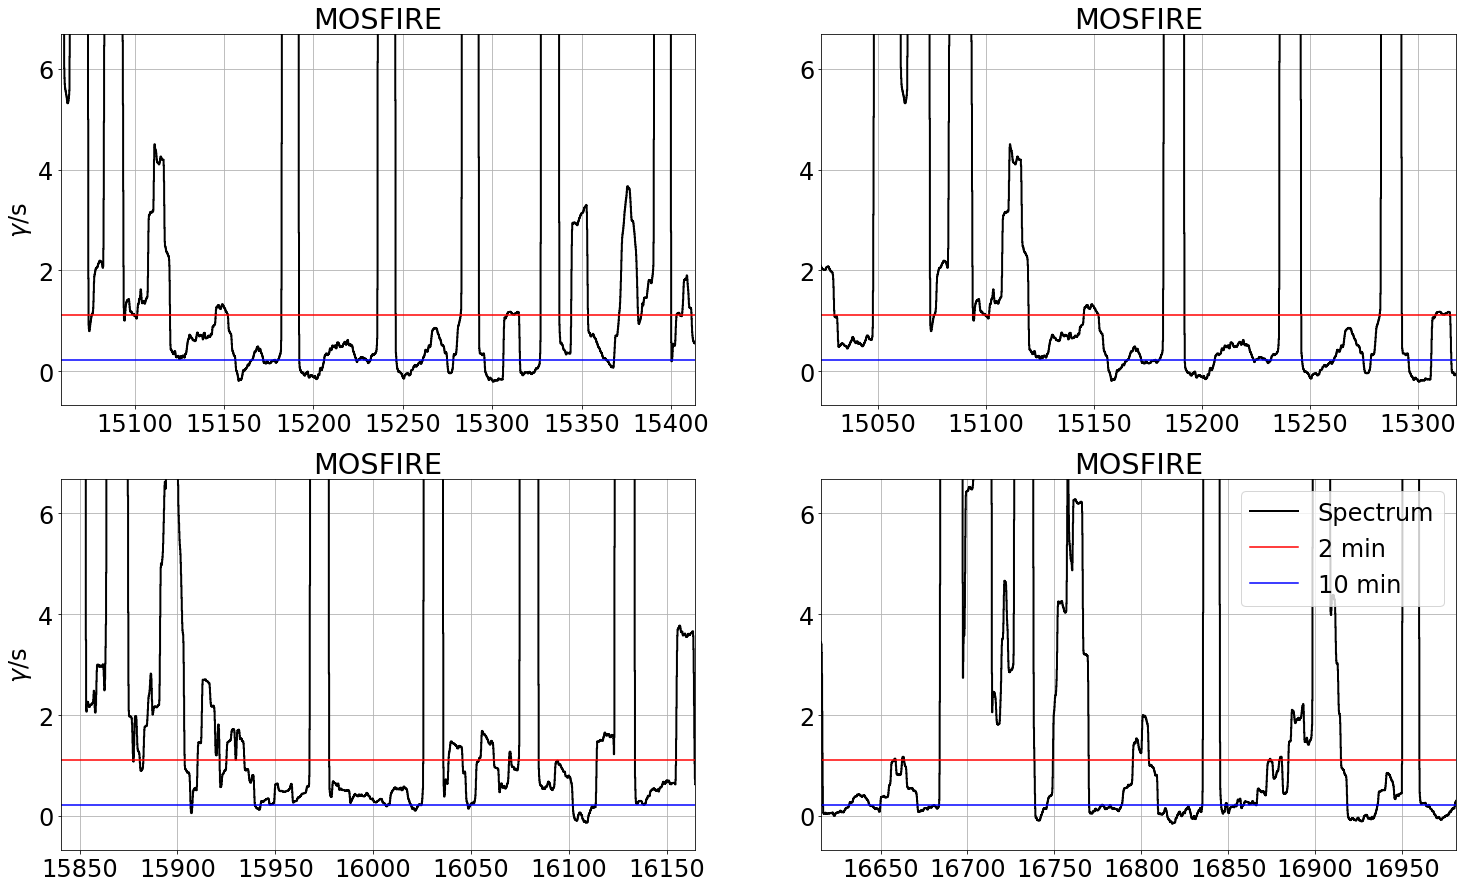

In [372]:

angs_to_mic = 1e4
locs = [(15180, 15290), (15145, 15195), (15968, 16035), (16750, 16845)]

F = .992
zpt = np.percentile(ssm,25)


for tel, G in Gs.items():

    fig = figure(figsize=(25,15))
    for ix, loc in enumerate(locs):
        subplot(2,2,ix+1)
        step(ll, ss_smooth * BW * G, 'k', lw=2)

        xlim(loc[0]*F, loc[1]/F)
        ylim(-.2*G, 2*G)
        title(tel)

        axhline(Goal/120, color='r')
        axhline(Goal/600, color='b')
        grid(True)

        if (ix % 2) == 0:
            ylabel("$\gamma$/s")

legend(["Spectrum", "2 min", "10 min"])
